In [1]:
from pathlib import Path
from operator import xor

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from hp_pred.experiments import load_labelized_cases
from hp_pred.test_model import TestModel

optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/aubouinb/Nextcloud2/Code/hypotension_pred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and format data

Available model:
xgb_no_filter: trained on 30_s_dataset, without filtering any point of the training set

In [2]:
# import the data frame and add the meta data to the segments

dataset_name = '30_s_dataset'
# dataset_name = 'chu_dataset'
model_filename = 'xgb_no_filter.json' #30_s_filtered.json' xgb_cycle
model_filename_2 = 'xgb_easy_point_filtered.json'
model_filename_3 = 'xgb_inter_filtered.json'
model_filename_4 = 'xgb_inter_easy_points_filtered.json'
feature_type="time"

In [3]:
data_clean = pd.read_parquet(f'data/datasets/{dataset_name}/cases', dtype_backend='pyarrow')
if feature_type == "wave" or feature_type == "mixt":
    data_wave = pd.read_parquet(f'data/datasets/{dataset_name}/wave_rocket_features/')
    data_clean = data_clean.merge(data_wave, left_on=['caseid', 'time'], right_on=['caseid', 'Time'])
    data_clean['label'] = data_clean['label_x']

static_clean = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data_clean = data_clean.merge(static_clean, on='caseid')
# test = data_clean[data_clean['caseid'].isin(test_caseid)]
test = data_clean[data_clean['split'] == 'test']

# test['label'] = test['label'] | test['intervention']

## Preprocessing

In [4]:
train = data_clean[data_clean['split'] == 'train']
# train = train[train['ioh_at_time_t']==0] 
# train = train[train['ioh_in_leading_time']==0]
# train = train[train['intervention'] == 0]
print(f"len train before filter: {len(train)} with a prevalence of {train['label'].mean():.2%}")

test = data_clean[data_clean['split'] == 'test']

# # test 2
test = test[test['ioh_at_time_t']==0] 
test = test[test['ioh_in_leading_time']==0]

# # # # test 3
test = test[test['intervention'] == 0] 

# test['label'] = xor(test['label'].astype(bool),test['intervention'])
print(f"len test before filter: {len(test)} with a prevalence of {test['label'].mean():.2%}")

#remove points at the end of the procedures when propo, remi and mac are null

# print(f"len test before filter: {len(test)} with a prevalence of {test['label'].mean():.2%}")
# print(f"Number of points removed label as hypotenstion: {test['label'].sum()}")
# test = test[~((test['pp_ct_constant_60'] == 0) & (test['rf_ct_constant_60'] == 0) & (test['mac_constant_60'] == 0))]
# print(f"len test after filter: {len(test)} with a prevalence of {test['label'].mean():.2%}")
# print(f"Number of points removed label as hypotenstion: {test['label'].sum()}")

len train before filter: 277075 with a prevalence of 10.33%
len test before filter: 71569 with a prevalence of 6.85%



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of points in the test data: 103527
Prevalence of hypotension: 9.36%
Test data loaded
Model 0 test:


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


Model 1 test:


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Model 2 test:


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Model 3 test:


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]




Results for test_1
Baseline
----- General stats -----
AUC: 0.82 (0.00)
AP: 0.41 (0.01)
AUPRC: 0.56 (0.01)
----- At threshold stats -----
Threshold: 0.43 [0.42, 0.43]
Recall: 38.0% [37.2%, 38.6%]
Precision: 66.1% (1.0%)
Specificity: 99.2% [99.1%, 99.2%]
NPV: 99.6% [99.6%, 99.6%]
F1-score: 48.2% [47.3%, 48.8%]


Model 0
----- General stats -----
AUC: 0.88 (0.00)
AP: 0.51 (0.01)
AUPRC: 0.68 (0.01)
----- At threshold stats -----
Threshold: 0.61 [0.61, 0.62]
Recall: 38.0% [37.9%, 38.1%]
Precision: 72.7% (1.0%)
Specificity: 99.4% (0.0%)
NPV: 99.6% (0.0%)
F1-score: 49.9% (0.3%)


Model 1
----- General stats -----
AUC: 0.87 (0.00)
AP: 0.41 (0.01)
AUPRC: 0.51 (0.01)
----- At threshold stats -----
Threshold: 0.31 [0.31, 0.31]
Recall: 38.0% [37.9%, 38.1%]
Precision: 53.9% (1.0%)
Specificity: 98.7% (0.1%)
NPV: 99.6% (0.0%)
F1-score: 44.6% (0.4%)


Model 2
----- General stats -----
AUC: 0.87 (0.00)
AP: 0.49 (0.01)
AUPRC: 0.66 (0.01)
----- At threshold stats -----
Threshold: 0.63 [0.62, 0.63]
Reca

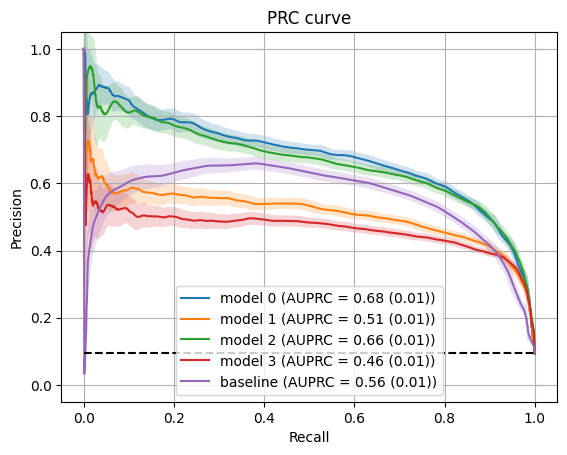

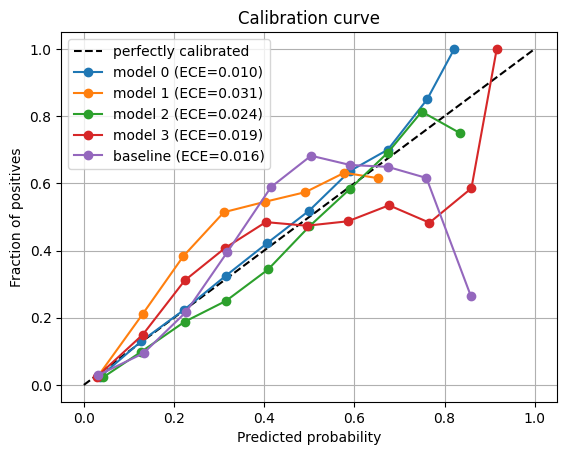

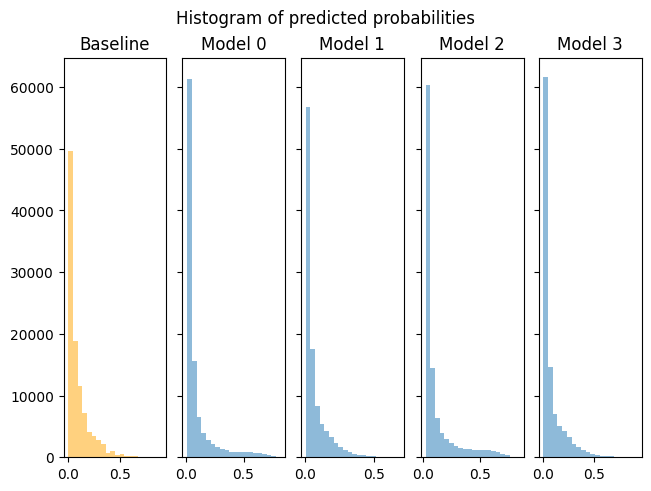

In [5]:
tester = TestModel(
    test,
    train,
    [model_filename, model_filename_2, model_filename_3, model_filename_4], # model_filename_2
    output_name='test_3',
)
tester.run(False, False)

## SHAP interpretations

In [ ]:
tester.compute_shap_value()
tester.plot_shap_values()
tester.group_shap_values()
tester.plot_shap_grouped()

## exemple of cases


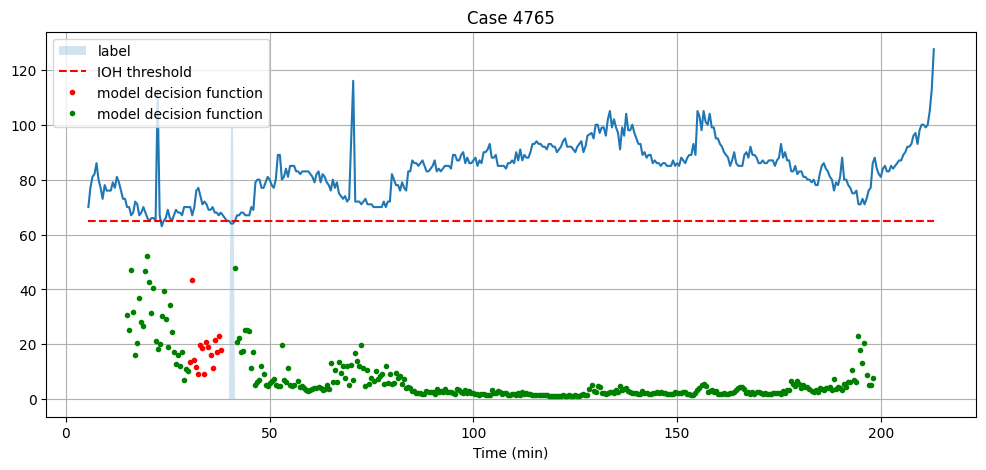

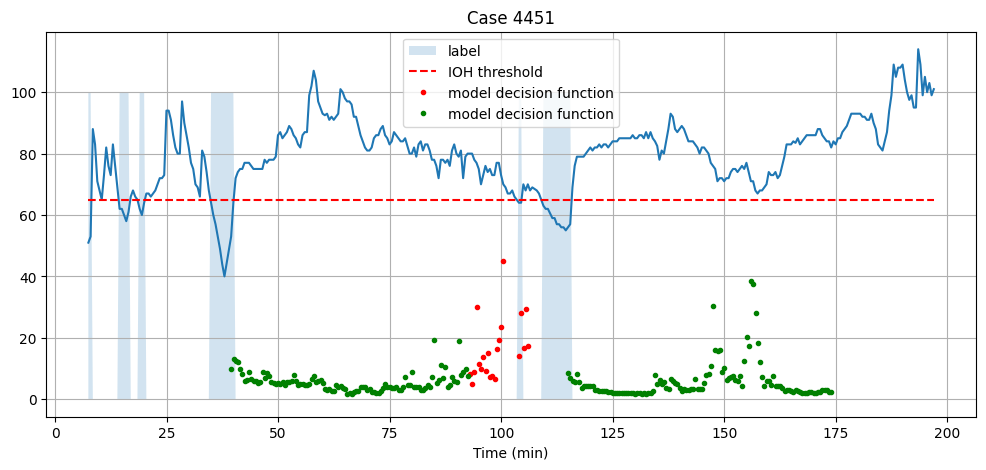

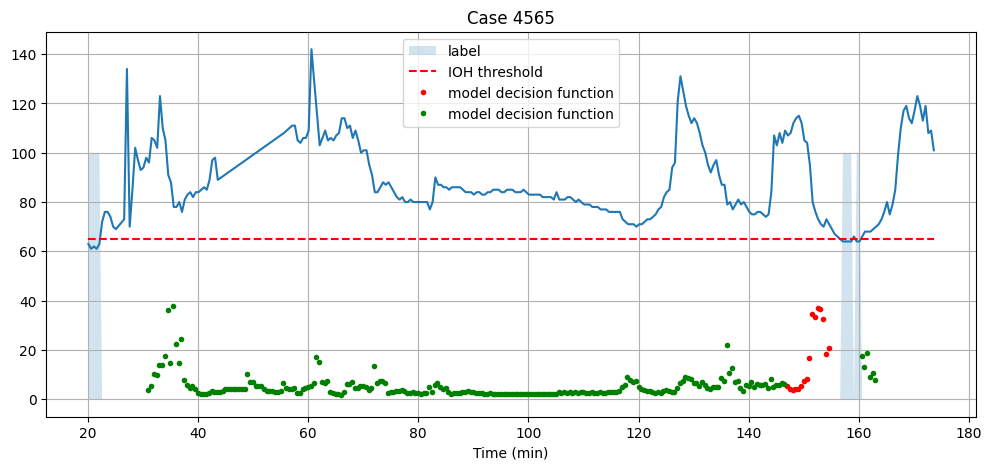

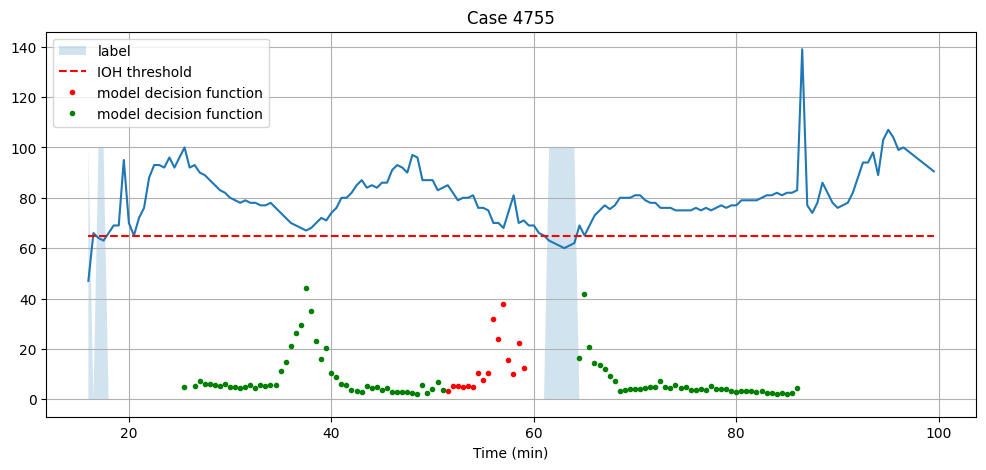

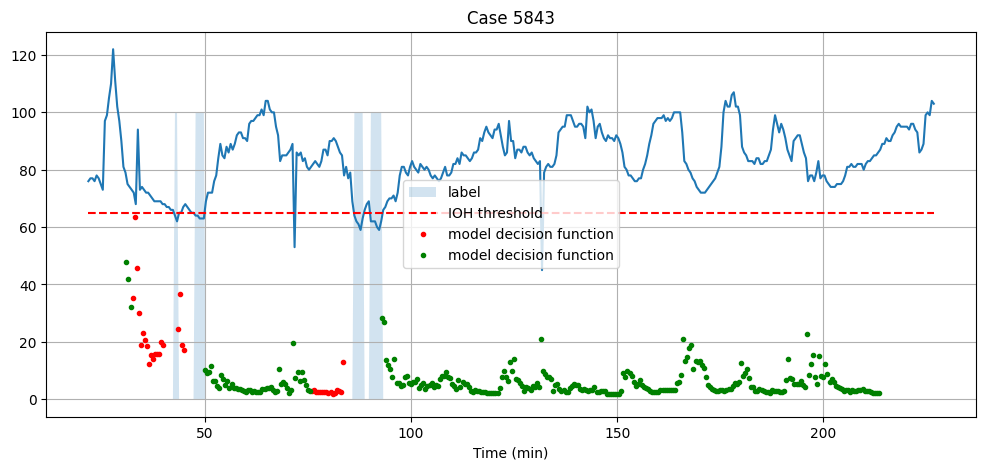

In [6]:
# plot 3 random cases with the corresponding decision function

np.random.seed(2)
cases = np.random.choice(test['caseid'].unique(), 5, replace=False)
model =tester.model[0]
features_names = tester.features_names
for case in cases:
    raw_case, mbp_column = load_labelized_cases(dataset_path=Path(f'data/datasets/{dataset_name}/'), caseid=int(case))

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=features_names)
    x_test = segment_data[features_names]
    y_pred = model.predict_proba(x_test)[:,1]

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case[mbp_column])
    # plt.plot(raw_case.index.seconds /60, raw_case['cycle_dPdt_max']/5)
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot([t.total_seconds()/60 for t in (segment_data[segment_data.label>0].time)] ,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot([t.total_seconds()/60 for t in (segment_data[segment_data.label==00].time)] ,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    # plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()


